# CBIR Demo 


## 1. How to use

#### step 0 : confirm your directory structure

The only thing is to prepare your image database directory and query directory as below. 

In [1]:
!tree /home/lzhu68/hd2t/Data/pg_data/Images | head -n10

/home/lzhu68/hd2t/Data/pg_data/Images
├── 00001.jpg
├── 00002.jpg
├── 00003.jpg
├── 00004.jpg
├── 00005.jpg
├── 00006.jpg
├── 00007.jpg
├── 00008.jpg
├── 00009.jpg


In [2]:
!tree /home/lzhu68/hd2t/Data/pg_data/Queries | head -n 10

/home/lzhu68/hd2t/Data/pg_data/Queries
├── 01.jpg
├── 01.txt
├── 02.jpg
├── 02.txt
├── 03.jpg
├── 03.txt
├── 04.jpg
├── 04.txt
├── 05.jpg


In [3]:
!cat /home/lzhu68/hd2t/Data/pg_data/Queries/03.txt
# each row is a bounding box in 'xywh' format

**Modify the following two lines to play on your own dataset.**

In [1]:
data_dir = '/home/lzhu68/hd2t/Data/pg_data/Images'
query_dir = '/home/lzhu68/hd2t/Data/pg_data/Queries'

#### step 1: import and create instantiate SearchEngine

* note that, if you build the database for the first time, it will consume somewhat a long time to extract features. (In my case it takes ~30 minutes for ~30k images with an NVIDIA 1080ti GPU).

* but once you finish building, setting up will be fast next time you intantiate SeachEngine, since we are using cache scheme.

* you are not suggested to do building setp on CPU, it will be **extremely slow**.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.search_engine import SearchEngine
from src.bow_extractor import BoWExtractor
from src.utils import load_image_and_bbs, draw_bbs_to_img
import cv2
import os

In [4]:
im_names = sorted(os.listdir(data_dir))
im_paths = [ os.path.join(data_dir, im_name) for im_name in im_names ]

In [5]:
print(im_paths[:5])

['/home/lzhu68/hd2t/Data/pg_data/Images/00001.jpg', '/home/lzhu68/hd2t/Data/pg_data/Images/00002.jpg', '/home/lzhu68/hd2t/Data/pg_data/Images/00003.jpg', '/home/lzhu68/hd2t/Data/pg_data/Images/00004.jpg', '/home/lzhu68/hd2t/Data/pg_data/Images/00005.jpg']


In [6]:
fea_extractor = BoWExtractor()
search_engine = SearchEngine(im_paths, fea_extractor)
search_engine.build()

error: OpenCV(4.2.0) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1210: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


#### step 2: prepare image and corresponding object bounding box to be retrieved

In [6]:
im_bb_path_tuples = [(os.path.join(query_dir, '{:02d}.jpg'.format(i)),
                      os.path.join(query_dir, '{:02d}.txt'.format(i))
                     ) for i in range(1, 51)
                    ]

/home/zhulei/Data/pg_data/Queries/25.jpg


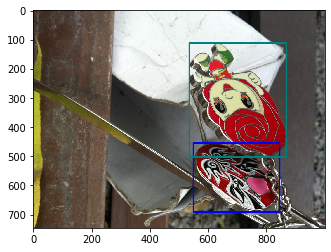

In [7]:
demo_im_path, demo_bb_path = im_bb_path_tuples[24]
print(demo_im_path)

demo_im, demo_bb = load_image_and_bbs(demo_im_path, demo_bb_path)
draw_bbs_to_img(demo_im, demo_bb)

#### step 3: call retrieve_object() or retrieve_img() function

2020-03-22 05:34:48,947 - INFO - computing bounding box for retrieved 10 images...
100%|██████████| 10/10 [00:00<00:00, 42.68it/s]


0.840286910533905 /home/zhulei/Data/pg_data/Images/15474.jpg
0.8389226794242859 /home/zhulei/Data/pg_data/Images/25749.jpg
0.8379632830619812 /home/zhulei/Data/pg_data/Images/04297.jpg
0.8376858830451965 /home/zhulei/Data/pg_data/Images/10996.jpg
0.8335717916488647 /home/zhulei/Data/pg_data/Images/20226.jpg
0.8332815170288086 /home/zhulei/Data/pg_data/Images/23376.jpg
0.8312265276908875 /home/zhulei/Data/pg_data/Images/01633.jpg
0.8309151530265808 /home/zhulei/Data/pg_data/Images/07463.jpg
0.830549418926239 /home/zhulei/Data/pg_data/Images/05846.jpg
0.8283413052558899 /home/zhulei/Data/pg_data/Images/22074.jpg


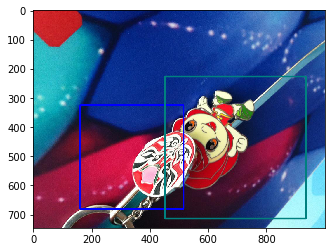

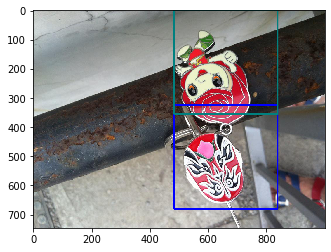

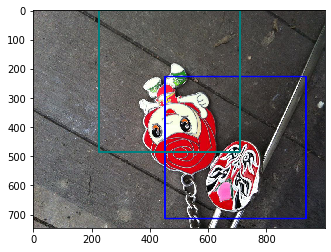

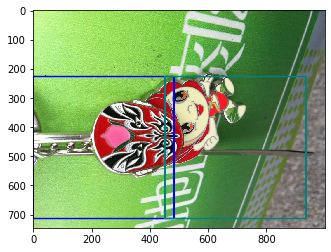

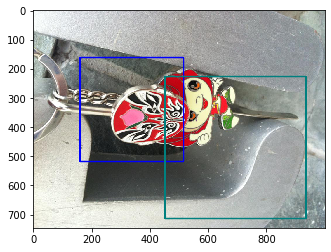

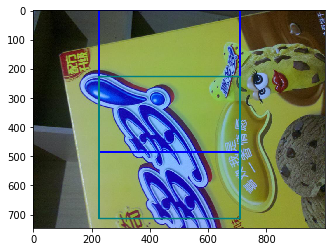

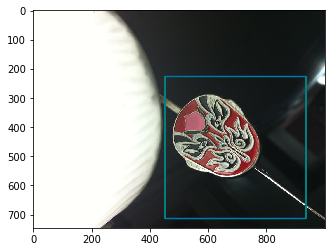

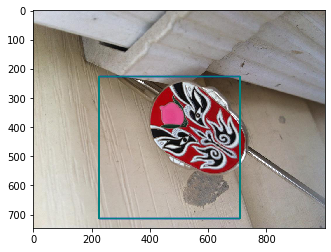

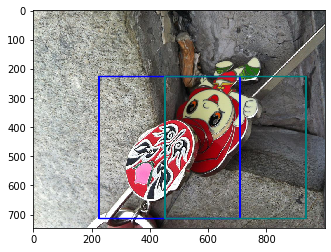

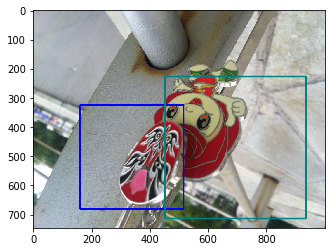

In [8]:
similar_imgs = search_engine.retrieve_object(demo_im, demo_bb, top_k=10)
for img_path, score, bbs in similar_imgs:
    print(score, img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    draw_bbs_to_img(img, bbs, 'ijhw_mat')

Of course,  without bounding boxes, we also support image-level retrival. In this way, no object region masking will be used as preprocessing, so the retrieved result may be different due to the effect of  background.

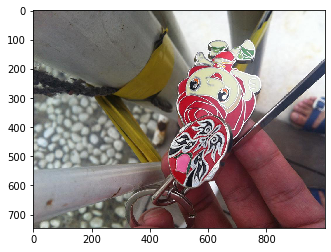

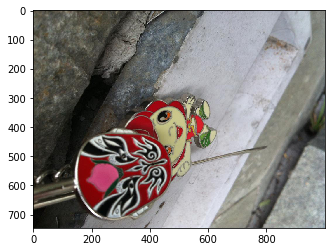

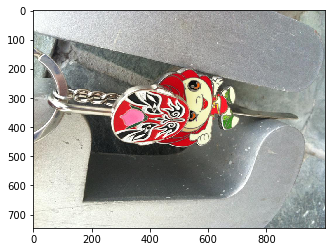

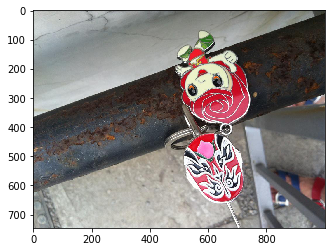

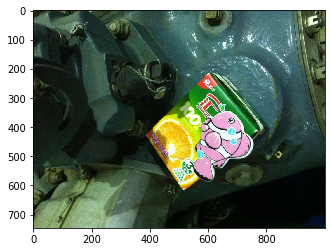

In [9]:
similar_imgs = search_engine.retrieve_img(demo_im, top_k=5)
for img_path, score in similar_imgs:
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    draw_bbs_to_img(img, None, 'ijhw_mat')

## 2. reproduce my result on the pg_data dataset

### 2.1 image retrieval and object localization for No. 1 - 5 query

In [10]:
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

In [11]:
for i, (im_path, bb_path) in enumerate(im_bb_path_tuples[:5], 1):
    im, bb = load_image_and_bbs(im_path, bb_path)
    similar_imgs = search_engine.retrieve_object(im, bb, top_k=10)
    save_dir = os.path.join(result_dir, 'Q{:d}'.format(i))
    os.makedirs(save_dir, exist_ok=True)
    # save query image to  path like result/Q1/match_top_0.png
    query_rgb = draw_bbs_to_img(im, bb, mode='return')
    query_bgr = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_dir, 'match_top_0.png'), query_bgr)
    for j, (sim_img_path, sim_score, sim_bbs) in enumerate(similar_imgs, 1):
        sim_img = cv2.cvtColor(cv2.imread(sim_img_path), cv2.COLOR_BGR2RGB)
        sim_img_with_bb = draw_bbs_to_img(sim_img, sim_bbs, 'ijhw_mat', mode='return')
        save_name = 'match_top_{:d}.png'.format(j)
        sim_img_with_bb = cv2.cvtColor(sim_img_with_bb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(save_dir, save_name), sim_img_with_bb)

2020-03-22 05:34:52,311 - INFO - computing bounding box for retrieved 10 images...
100%|██████████| 10/10 [00:00<00:00, 52.41it/s]
2020-03-22 05:34:52,878 - INFO - computing bounding box for retrieved 10 images...
100%|██████████| 10/10 [00:00<00:00, 52.92it/s]
2020-03-22 05:34:53,434 - INFO - computing bounding box for retrieved 10 images...
100%|██████████| 10/10 [00:00<00:00, 11.81it/s]
2020-03-22 05:34:54,652 - INFO - computing bounding box for retrieved 10 images...
100%|██████████| 10/10 [00:00<00:00, 45.29it/s]
2020-03-22 05:34:55,189 - INFO - computing bounding box for retrieved 10 images...
100%|██████████| 10/10 [00:00<00:00, 119.77it/s]


No we can visualize result as below.  The table has 11 rows, 5 columns, each column is for one query. In each column, the first one is query image, followed by ten retrieved ones. You may go to `result` directory to see full size images, so that the content and bounding boxes are more clear.

| Q1 | Q2 | Q3 | Q4 | Q5 |
| - | - | - | - | - |
| ![](result/Q1/match_top_0.png) | ![](result/Q2/match_top_0.png) | ![](result/Q3/match_top_0.png) | ![](result/Q4/match_top_0.png) | ![](result/Q5/match_top_0.png) |
| ![](result/Q1/match_top_1.png) | ![](result/Q2/match_top_1.png) | ![](result/Q3/match_top_1.png) | ![](result/Q4/match_top_1.png) | ![](result/Q5/match_top_1.png) |
| ![](result/Q1/match_top_2.png) | ![](result/Q2/match_top_2.png) | ![](result/Q3/match_top_2.png) | ![](result/Q4/match_top_2.png) | ![](result/Q5/match_top_2.png) |
| ![](result/Q1/match_top_3.png) | ![](result/Q2/match_top_3.png) | ![](result/Q3/match_top_3.png) | ![](result/Q4/match_top_3.png) | ![](result/Q5/match_top_3.png) |
| ![](result/Q1/match_top_4.png) | ![](result/Q2/match_top_4.png) | ![](result/Q3/match_top_4.png) | ![](result/Q4/match_top_4.png) | ![](result/Q5/match_top_4.png) |
| ![](result/Q1/match_top_5.png) | ![](result/Q2/match_top_5.png) | ![](result/Q3/match_top_5.png) | ![](result/Q4/match_top_5.png) | ![](result/Q5/match_top_5.png) |
| ![](result/Q1/match_top_6.png) | ![](result/Q2/match_top_6.png) | ![](result/Q3/match_top_6.png) | ![](result/Q4/match_top_6.png) | ![](result/Q5/match_top_6.png) |
| ![](result/Q1/match_top_7.png) | ![](result/Q2/match_top_7.png) | ![](result/Q3/match_top_7.png) | ![](result/Q4/match_top_7.png) | ![](result/Q5/match_top_7.png) |
| ![](result/Q1/match_top_8.png) | ![](result/Q2/match_top_8.png) | ![](result/Q3/match_top_8.png) | ![](result/Q4/match_top_8.png) | ![](result/Q5/match_top_8.png) |
| ![](result/Q1/match_top_9.png) | ![](result/Q2/match_top_9.png) | ![](result/Q3/match_top_9.png) | ![](result/Q4/match_top_9.png) | ![](result/Q5/match_top_9.png) |
| ![](result/Q1/match_top_10.png) | ![](result/Q2/match_top_10.png) | ![](result/Q3/match_top_10.png) | ![](result/Q4/match_top_10.png) | ![](result/Q5/match_top_10.png) |

### 2.2 image retrieval for all queries

* if using normally small `top_k` such as 10 or 50, all 50 queries will be finished fast (~2s).
* however, with `top_k` as large as number of images (~30k) in database, it takes ~30s to finish queries.
* Another intresting discovery: when `top_k` is set to so large, the returned scores and thus rank is slightly different from small `top_k`. It turns out to be a [precision problem with torch.topk()](https://github.com/pytorch/pytorch/issues/3462).
    - you can modify `DEBUG` flag to True to see what happened
    
    ![](assets/torch_topk_problem.png)

In [12]:
import pandas as pd
from tqdm import tqdm
import string
import time

DEBUG = False

def im_path_to_id(im_path):
    im_name = os.path.basename(im_path)
    im_id = int(os.path.splitext(im_name)[0]) # to remove leading zeros
    return str(im_id)

num_imgs = len(os.listdir(data_dir))
print('number of images in database: {:d}'.format(num_imgs))
print('processing queries...')
time.sleep(1) # just to avoid print function to interupt progress bar which makes me uncomfortable

rankfile = os.path.join(result_dir, 'rankList.txt')
with open(rankfile, 'w') as f:
    i = 1
    for (im_path, bb_path) in tqdm(im_bb_path_tuples, disable=DEBUG):
        im, bb = load_image_and_bbs(im_path, bb_path)
        similar_imgs = search_engine.retrieve_object(im, bb, locate=False, top_k=num_imgs)
        line = 'Q{:d}: '.format(i)
        
        # set DEBUG flag to True, compare Q24 output to rank and scores in Section 1.3
        # you will find that the top 10 score and rank are slightly different
        if DEBUG:
            print(line+' '.join([ im_path_to_id(x[0]) for x in similar_imgs[:10] ]))
            print('score: ' + ' '.join([ '{:.4f}'.format(x[1]) for x in similar_imgs[:10] ]))
        line += ' '.join([ im_path_to_id(x[0]) for x in similar_imgs ])
        line +='\n'
        f.writelines(line)
        i += 1
        

number of images in database: 28493
processing queries...


100%|██████████| 50/50 [00:34<00:00,  1.48it/s]


The following is structure of directory after all above being run.

In [1]:
! tree result

result
├── Q1
│   ├── match_top_0.png
│   ├── match_top_10.png
│   ├── match_top_1.png
│   ├── match_top_2.png
│   ├── match_top_3.png
│   ├── match_top_4.png
│   ├── match_top_5.png
│   ├── match_top_6.png
│   ├── match_top_7.png
│   ├── match_top_8.png
│   └── match_top_9.png
├── Q2
│   ├── match_top_0.png
│   ├── match_top_10.png
│   ├── match_top_1.png
│   ├── match_top_2.png
│   ├── match_top_3.png
│   ├── match_top_4.png
│   ├── match_top_5.png
│   ├── match_top_6.png
│   ├── match_top_7.png
│   ├── match_top_8.png
│   └── match_top_9.png
├── Q3
│   ├── match_top_0.png
│   ├── match_top_10.png
│   ├── match_top_1.png
│   ├── match_top_2.png
│   ├── match_top_3.png
│   ├── match_top_4.png
│   ├── match_top_5.png
│   ├── match_top_6.png
│   ├── match_top_7.png
│   ├── match_top_8.png
│   └── match_top_9.png
├── Q4
│   ├── match_top_0.png
│   ├── match_top_10.png
│   ├── match_top_1.png
│   ├── match_top_2.png
│   ├── match_top_3.png
│   ├── match_top_4.png
│   ├── match_top_5.png
│